In [2]:
%load_ext autoreload
%autoreload 1

In [32]:
%aimport vae
%aimport distributions
%aimport y_utils
%aimport samplers
%aimport warmup_schedules
from y_utils import *
from vae import VAE, get_filename
from samplers import *
from distributions import Banana, Funnel
from distribution_metrics import *
import torch
from matplotlib import pyplot as plt
import numpy as np
import time

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [5]:
D = 32  # Data dimensionality
target = Banana(dim=D, sigma=5.0, b=0.02, device=device)

In [17]:
distribution_metric = wasserstein_metric
metric_name = 'Wasserstein Metric'

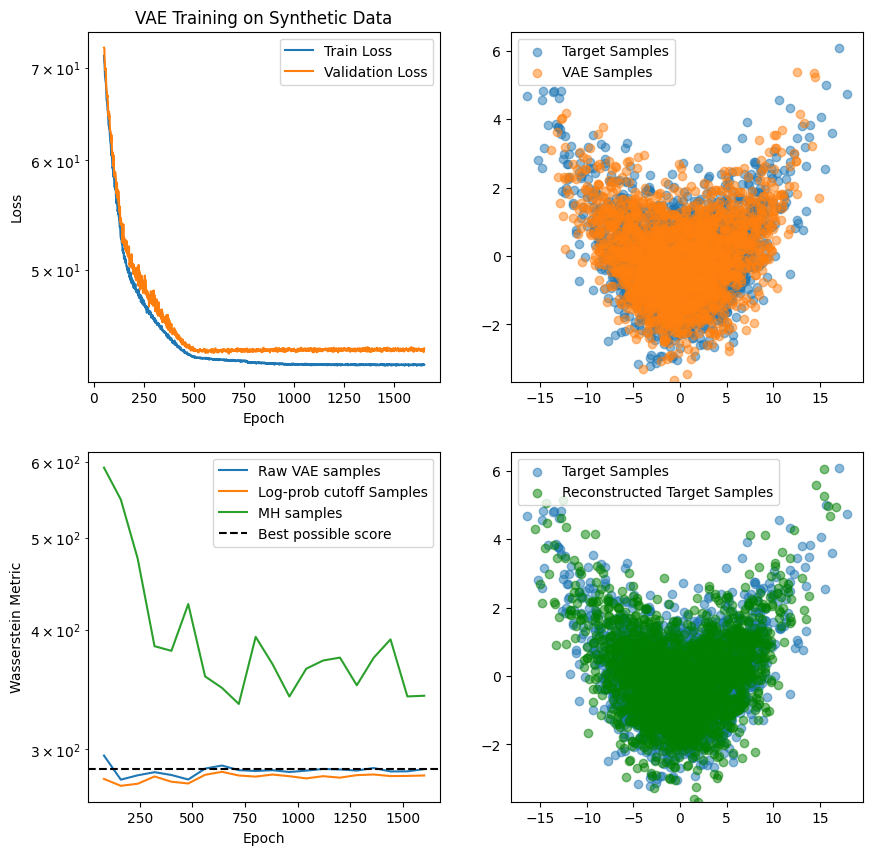

Epoch 1650
	Train loss: 42.7019
	Validation loss: 43.8693
	Learning rate: 9.765625e-06


In [39]:
kl_penalty = 1
hidden_dims = (128, 128, 128, 128)
latent_dim = D
N_train = 16_384
model = VAE(data_dim=D, hidden_dims=hidden_dims, latent_dim=latent_dim, device=device)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
patience = 90
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=patience, threshold=1e-4)
# scheduler = None
model.fit_distribution(target, kl_penalty, N_train, optimizer,
                       scheduler=scheduler, max_epochs=2000, 
                       kl_annealing_epochs=500, batch_size=2_048,
                      distribution_metric=distribution_metric)

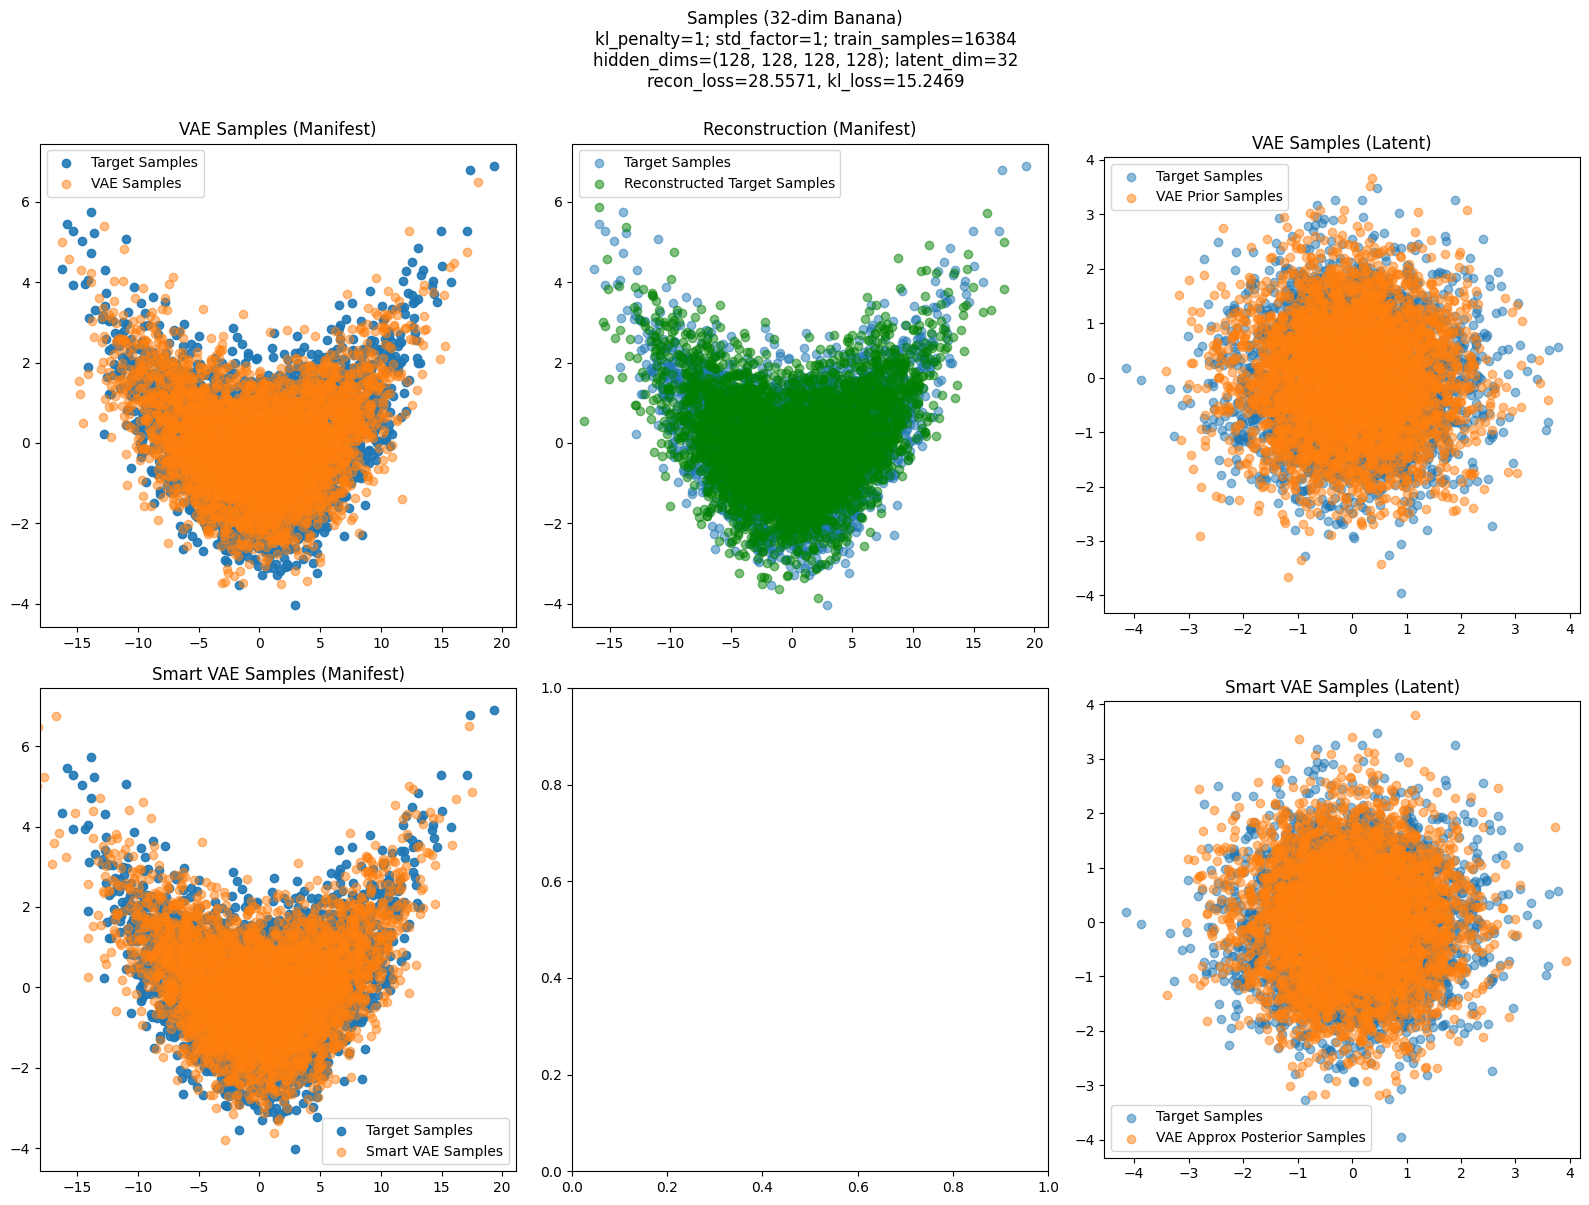

In [40]:
#%%time
torch.cuda.empty_cache()

N = 4000
std_factor = 1
model.set_std_factor(std_factor)
target_samples = target.sample((N,))
reconstructed_target = model.reconstruct(target_samples)
target_latent = model.encode(target_samples)
vae_latent = model.sample_prior(N, std_factor)
vae_latent_smart = model.sample_latent((N,))
vae_samples = model.decode(vae_latent)
vae_samples_smart = model.decode(vae_latent_smart)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))
ax1 = axs[0][0]
ax2 = axs[0][1]
ax3 = axs[0][2]
ax4 = axs[1][0]
ax5 = axs[1][1]
ax6 = axs[1][2]
axs = axs.flatten()

proj_dims1 = (0, 1)
ax1.scatter(*pl(target_samples[:, proj_dims1]), alpha=0.9, label='Target Samples')
ax1.scatter(*pl(vae_samples[:, proj_dims1]), alpha=0.5, label='VAE Samples')
ax1.legend()
ax1.set_title('VAE Samples (Manifest)')

ax4.set_xlim(ax1.get_xlim())
ax4.set_ylim(ax1.get_ylim())
ax4.scatter(*pl(target_samples[:, proj_dims1]), alpha=0.9, label='Target Samples')
ax4.scatter(*pl(vae_samples_smart[:, proj_dims1]), alpha=0.5, label='Smart VAE Samples')
ax4.legend()
ax4.set_title('Smart VAE Samples (Manifest)')

ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
ax2.scatter(*pl(target_samples[:, proj_dims1]), alpha=0.5, label='Target Samples')
ax2.scatter(*pl(reconstructed_target[:, proj_dims1]), alpha=0.5, label='Reconstructed Target Samples', color='green')
ax2.set_title('Reconstruction (Manifest)')
ax2.legend()

proj_dims2 = (0, 1)
ax3.scatter(*pl(target_latent[:, proj_dims2]), alpha=0.5, label='Target Samples')
ax3.scatter(*pl(vae_latent[:, proj_dims2]), alpha=0.5, label='VAE Prior Samples')
ax3.set_aspect('equal', adjustable='box')
ax3.set_title('VAE Samples (Latent)')
ax3.legend()

ax6.set_xlim(ax3.get_xlim())
ax6.set_ylim(ax3.get_ylim())
ax6.scatter(*pl(target_latent[:, proj_dims2]), alpha=0.5, label='Target Samples')
ax6.scatter(*pl(vae_latent_smart[:, proj_dims2]), alpha=0.5, label='VAE Approx Posterior Samples')
ax6.set_aspect('equal', adjustable='box')
ax6.set_title('Smart VAE Samples (Latent)')
ax6.legend()


recon_loss, kl_loss = model.loss_components(target_samples)
plt.suptitle(
    f'''Samples ({D}-dim Banana)
    kl_penalty={kl_penalty}; std_factor={std_factor}; train_samples={N_train}
    hidden_dims={hidden_dims}; latent_dim={latent_dim}
    recon_loss={recon_loss:.4f}, kl_loss={kl_loss:.4f}''', y=1);
plt.tight_layout()

In [38]:
torch.cuda.empty_cache()

CPU times: total: 1.64 s
Wall time: 1.64 s


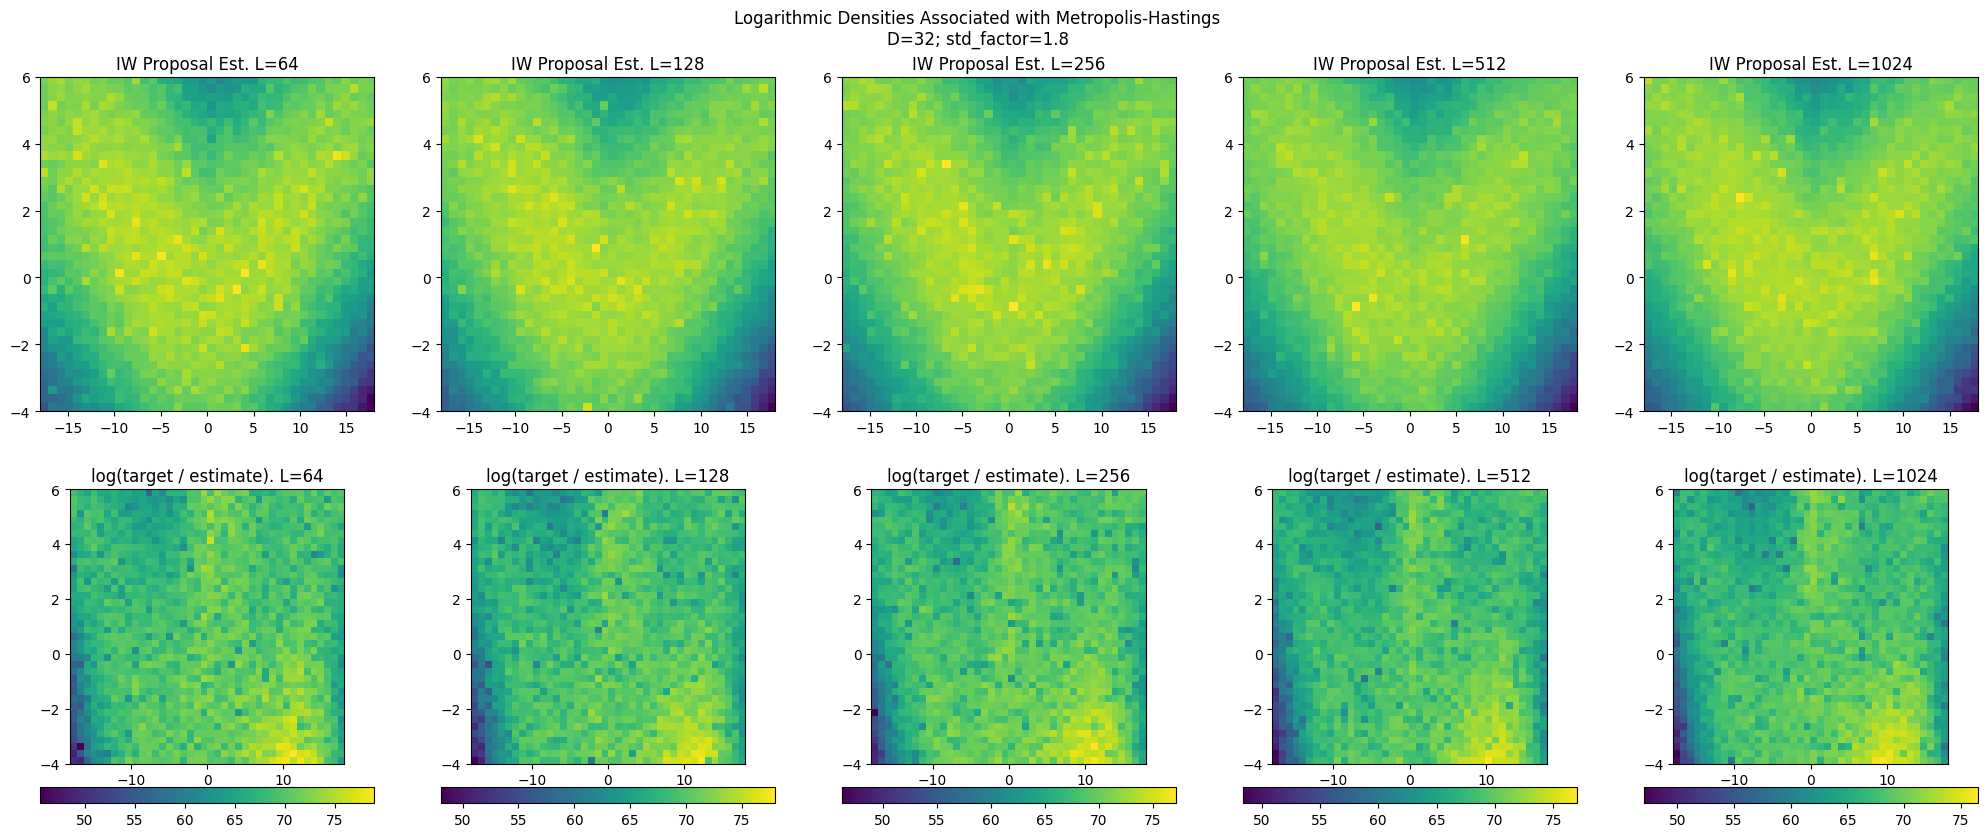

In [79]:
%%time
def plot_proposal_density_estimates():
    xlim=(-18, 18)
    ylim = (-4, 6)
    ratio = (xlim[1] - xlim[0]) / (ylim[1] - ylim[0])
    d = 40
    proj_dims = (0, 1)
    x = np.linspace(*xlim, d)
    y = np.linspace(*ylim, d)
    X, Y = np.meshgrid(x, y)
    X, Y = torch.tensor(X), torch.tensor(Y)

    points = torch.zeros(d, d, D, device=device)
    points[..., proj_dims[0]] = X
    points[..., proj_dims[1]] = Y
    
    std_factor = 1.8
    model.set_std_factor(std_factor)

    target_log_density = target.log_prob(points)
    L_options = [64, 128, 256, 512, 1024]
    K = len(L_options)
    fig, axs = plt.subplots(ncols=K, nrows=2, figsize=(5 * K, 10))
    axs = axs.flatten()
    
    
    #ax1 = axs[-1]
    #img1 = ax1.imshow(target_log_density.detach().cpu(), origin='lower', extent=[*xlim, *ylim], aspect='auto')
    #ax1.set_aspect(ratio)
    #ax1.set_title('Target Logarithmic Density')
    #fig.colorbar(img1, ax=ax1)
    
    for ax1, ax2, L in zip(axs, axs[K:], L_options):
        log_marginal_estimates = model.iw_log_marginal_estimate(points.flatten(end_dim=1), L=L, batch_L=64).unflatten(dim=0, sizes=(d, d))
        log_ratio = target_log_density - log_marginal_estimates
        ax1.imshow(log_marginal_estimates.detach().cpu(), origin='lower', extent=[*xlim, *ylim], aspect='auto')
        ax1.set_aspect(ratio)
        ax1.set_title(f'IW Proposal Est. L={L}')

        #n_colors = 256
        cmap = plt.get_cmap('viridis')
        #ticks=np.linspace(log_ratio.detach().cpu().numpy().min(), log_ratio.detach().cpu().numpy().max(), n_colors + 1)
        img2 = ax2.imshow(log_ratio.detach().cpu(), origin='lower', cmap=cmap, extent=[*xlim, *ylim], aspect='auto')
        ax2.set_aspect(ratio)
        ax2.set_title(f'log(target / estimate). L={L}')
        #ax2.set_xticks([])
        #ax2.set_yticks([])
        cbar = fig.colorbar(img2, ax=ax2, orientation='horizontal', pad=0.065)
        # cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=70)
        #cbar.ax.set_xticklabels([f"{x:.1f}" for x in ticks], rotation=70)

    
    plt.suptitle(f'Logarithmic Densities Associated with Metropolis-Hastings\nD={D}; std_factor={std_factor}', y=0.94);
    
    torch.cuda.empty_cache()
    
    #vmin1, vmax1 = img1.get_clim()
    #vmin2, vmax2 = img2.get_clim()
    #clim = (min(vmin1, vmin2), max(vmax1, vmax2))
    #img1.set_clim(*clim)
    #img2.set_clim(*clim)

plot_proposal_density_estimates()

CPU times: total: 9.75 s
Wall time: 9.77 s


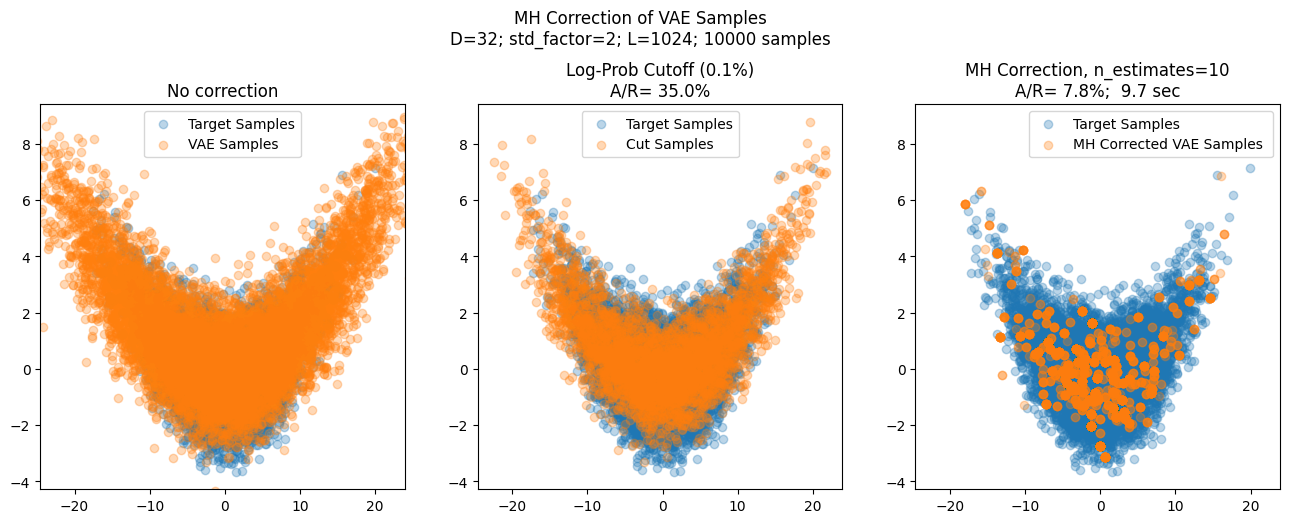

In [43]:
%%time

def plot_approx_mh_samples():
    std_factor = 2
    model.set_std_factor(std_factor)
    
    N = 10000
    L = 1024
    q = 0.001
    n_estimates=10
    model_samples = model.sample((N,))
    proposal_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, batch_L=32)

    cutoff_quantile = get_log_prob_quantile(target, q)
    cut_acc_rate, cut_indicies = log_prob_cutoff_filter(target, model_samples, cutoff_quantile)
    cut_samples = model_samples[cut_indicies]
    _time1 = time.time()
    acc_rate1, mh_indicies = metropolis_hastings_filter(target, cut_samples, proposal_log_prob_estimator, n_estimates=n_estimates)
    mh_samples = cut_samples[mh_indicies]
    _time2 = time.time()
    
    _time3 = time.time()
    mh_time = _time2 - _time1
    mh_reeval_time =  _time3 - _time2
    
    target_samples = target.sample((N,))
    #vae_samples = proposer((N,))
    
    proj_dims = (0, 1)
    alpha=0.3
    
    fig, axs = plt.subplots(ncols=3, figsize=(16, 5))
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    
    ax1.scatter(*pl(target_samples[:, proj_dims]), alpha=alpha, label='Target Samples')
    ax1.scatter(*pl(model_samples[:, proj_dims]), alpha=alpha, label='VAE Samples')
    ax1.set_title('No correction')

    ax2.scatter(*pl(target_samples[:, proj_dims]), alpha=alpha, label='Target Samples')
    ax2.scatter(*pl(cut_samples[:, proj_dims]), alpha=alpha, label='Cut Samples')
    ax2.legend()
    ax2.set_title(f'Log-Prob Cutoff ({100*q:0.1f}%)\nA/R={100 * cut_acc_rate: 0.1f}%')
    
    ax3.scatter(*pl(target_samples[:, proj_dims]), alpha=alpha, label='Target Samples')
    ax3.scatter(*pl(mh_samples[:, proj_dims]), alpha=alpha, label='MH Corrected VAE Samples ')
    ax3.set_title(f'MH Correction, n_estimates={n_estimates}\nA/R={100 * acc_rate1: 0.1f}%; {mh_time: 0.1f} sec')
    
    for ax in axs:
        ax.set_xlim(ax2.get_xlim())
        ax.set_ylim(ax2.get_ylim())
        ax.legend()

    plt.suptitle(f'MH Correction of VAE Samples\nD={D}; std_factor={std_factor}; L={L}; {N} samples', y=1.07)

    torch.cuda.empty_cache()

torch.cuda.empty_cache()
plot_approx_mh_samples()

In [44]:
model.save_knowledge('models/kl' + str(kl_penalty) + ' ' + get_filename(model, target))
torch.cuda.empty_cache()